<a href="https://colab.research.google.com/github/KelseyWang2022/accident_data_analysis/blob/main/GAN_data_balance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy torch sklearn matplotlib

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


grav
minor injury    10759
no injury       10426
severe           2916
death              79
Name: count, dtype: int64


Epoch [0/5000] - D Loss: 10.882976531982422, G Loss: 0.5869523882865906
Epoch [1000/5000] - D Loss: 3.7135283946990967, G Loss: 1.2891764640808105
Epoch [2000/5000] - D Loss: 2.458862543106079, G Loss: 1.1436550617218018
Epoch [3000/5000] - D Loss: 2.187199592590332, G Loss: 1.3560508489608765
Epoch [4000/5000] - D Loss: 1.9546771049499512, G Loss: 1.4361462593078613


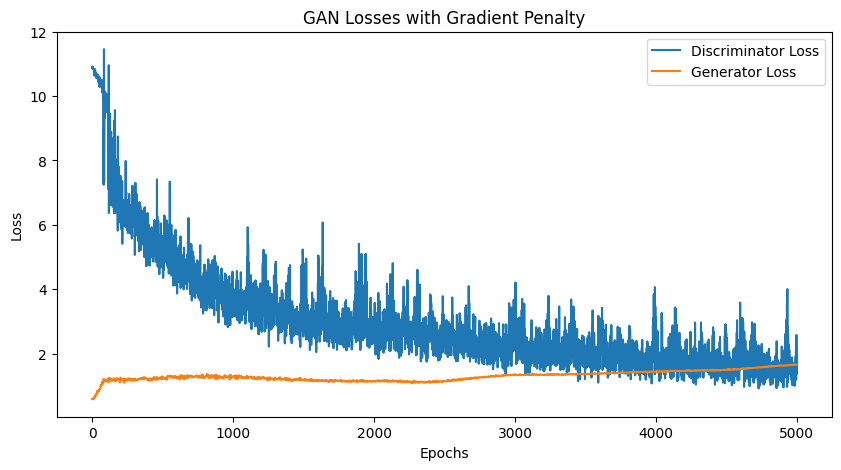


Max class count: 10759
Class 2 count: 2995
Needed class 2 samples: 7764
Synthetic data generated and added to the dataset.


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 加载数据
file_path = r'/content/ordered_probit_data.csv'  # 根据实际路径调整
chunk_size = 10000
chunks = pd.read_csv(file_path, chunksize=chunk_size)

# 处理并合并数据块
data_list = []
for chunk in chunks:
    data_list.append(chunk)

data = pd.concat(data_list, ignore_index=True)

# 应用 Label Encoding 并填充缺失值
categorical_cols = ['season', 'peak', 'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'grav']  # 移除 'grav'
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

# 填充缺失值
data.fillna(data.mean(), inplace=True)

# 正确映射 'grav' 列到 'grav_encoded'
grav_mapping = {
    0: 2,  # death -> 2
    1: 1,  # minor injury -> 1
    2: 0,  # no injury -> 0
    3: 2   # severe -> 2
}
data['grav_encoded'] = data['grav'].map(grav_mapping)

# 过滤类别2（severe + death）用于 GAN 生成
class_2_data = data[data['grav_encoded'] == 2]
X_class_2 = class_2_data.drop(columns=['grav', 'grav_encoded']).astype(np.float32)

# 定义 GAN 的生成器和判别器
class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, output_size)
        )
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')

    def forward(self, x):
        return torch.clamp(self.fc(x), min=0.0, max=1.0)

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')

    def forward(self, x):
        return self.fc(x)

# 使用WGAN-GP方法，增加Gradient Penalty来改进训练
def gradient_penalty(discriminator, real_data, fake_data, device):
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1, device=device)
    epsilon = epsilon.expand_as(real_data)

    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated = interpolated.requires_grad_(True)

    prob_interpolated = discriminator(interpolated)

    gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                                    grad_outputs=torch.ones(prob_interpolated.size()).to(device),
                                    create_graph=True, retain_graph=True)[0]

    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)

    penalty = ((gradient_norm - 1) ** 2).mean()
    return penalty

# GAN 训练函数，加入梯度惩罚，retain_graph=True 确保不会释放图
def train_gan(generator, discriminator, data, epochs=5000, batch_size=64, lambda_gp=10):
    criterion = nn.BCELoss()
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0001)
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.00005)
    noise_size = 100
    d_losses = []
    g_losses = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)

    # 如果样本数小于 batch_size，则调整 batch_size
    if len(data) < batch_size:
        batch_size = len(data)

    for epoch in range(epochs):
        # 生成真实数据
        real_data = torch.tensor(data.sample(batch_size).values, dtype=torch.float32).to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        noise = torch.randn(batch_size, noise_size).to(device)
        fake_data = generator(noise)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # 训练判别器，加入gradient penalty
        optimizer_d.zero_grad()
        outputs_real = discriminator(real_data)
        outputs_fake = discriminator(fake_data.detach())
        loss_real = criterion(outputs_real, real_labels)
        loss_fake = criterion(outputs_fake, fake_labels)

        # 计算梯度惩罚
        gp = gradient_penalty(discriminator, real_data, fake_data, device)
        d_loss = loss_real + loss_fake + lambda_gp * gp
        d_loss.backward(retain_graph=True)  # 加入retain_graph
        optimizer_d.step()

        # 每隔5次训练判别器，生成器更新一次
        if epoch % 5 == 0:
            # 训练生成器
            optimizer_g.zero_grad()
            outputs_fake = discriminator(fake_data)
            g_loss = criterion(outputs_fake, real_labels)
            g_loss.backward(retain_graph=True)  # 加入retain_graph
            optimizer_g.step()

        # 记录损失
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        if epoch % 1000 == 0:
            print(f"Epoch [{epoch}/{epochs}] - D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

    # 绘制损失曲线
    plt.figure(figsize=(10,5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('GAN Losses with Gradient Penalty')
    plt.show()

    return generator

# 初始化 GAN 组件
input_size = X_class_2.shape[1]
generator = Generator(100, input_size)
discriminator = Discriminator(input_size)

# 训练 GAN
generator = train_gan(generator, discriminator, X_class_2)

# 生成合成数据平衡类别2
class_counts = data['grav_encoded'].value_counts()
max_class_count = class_counts.max()
class_2_count = class_counts.get(2, 0)
needed_class_2_samples = max_class_count - class_2_count
needed_class_2_samples = int(needed_class_2_samples) if needed_class_2_samples > 0 else 0



print(f"\nMax class count: {max_class_count}")
print(f"Class 2 count: {class_2_count}")
print(f"Needed class 2 samples: {needed_class_2_samples}")

if needed_class_2_samples > 0:
    noise = torch.randn(needed_class_2_samples, 100)
    generated_data = generator(noise).detach().numpy()

    generated_class_2 = pd.DataFrame(generated_data, columns=X_class_2.columns)
    generated_class_2['grav_encoded'] = 2

    balanced_data = pd.concat([data, generated_class_2], ignore_index=True)
    print("Synthetic data generated and added to the dataset.")
else:
    balanced_data = data.copy()
    print("No additional samples needed for Class 2. Using original data as balanced_data.")

# 保存平衡后的数据为 CSV 文件
balanced_data.to_csv(r'/content/balanced_data.csv', index=False)  # 根据需要调整路径


In [ ]:
#查看生成后的
print(balanced_data['grav_encoded'].value_counts())

grav_encoded
2    10759
1    10759
0    10426
Name: count, dtype: int64


In [ ]:
#查看grav原始值和映射值
print(data['grav'].value_counts())
print(data['grav_encoded'].value_counts())

grav
1    10759
2    10426
3     2916
0       79
Name: count, dtype: int64
grav_encoded
1    10759
0    10426
2     2995
Name: count, dtype: int64
